In [4]:
#Import libraries

import ee 
import geemap
import xee
import xarray as xr
import datetime
import rioxarray as rxr
import os
import ipyleaflet
import gdown
import rasterio
from rasterio import features
from osgeo import gdal, ogr, osr
import os, glob, re, csv
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import json
import geopandas as gpd
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, colors, rc
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates

In [5]:
#Inputs:
pf = "14_387" #manually input, since GEE index differently!

cwd = os.getcwd()
json_path = os.path.join(cwd, "dict.json")

with open(json_path, "r") as file:
    loaded_sar_data = json.load(file)

path = int(next(iter(loaded_sar_data['1']['path_frame_dict'])))
frame = int(loaded_sar_data['1']['path_frame_dict'][str(path)][0])
#print(path, frame)
out_nc_fn = loaded_sar_data['1']['cube_fn']
filename = os.path.basename(out_nc_fn)   
rgi_id = filename.split("_")[1].split(".")[0]
tifs_path = os.path.join(cwd, 'tifs_single_glacier') #type Path
gl_path = os.path.join(tifs_path, rgi_id)
csv_path = os.path.join(cwd, 'csv\\')
fig_fp = os.path.join(cwd, 'fig\\')
dem_path = os.path.join(gl_path, 'DEM.tif')
print(str(dem_path))

# all processed path/frame datacubes
loaded_sar_data

c:\Users\jaden\Downloads\Research\csv_comp\tifs_single_glacier\01-06125\DEM.tif


{'1': {'location_str': 'Kennicott',
  'scene_name': 'Kennicott',
  'cube_fn': 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\nc\\merged_01-06125.nc',
  'epsg_no': '32607',
  'path_frame_dict': {'14': ['5']},
  'Direction': 'Ascending',
  'frame_cut': 0,
  'pol_str': 'VH'}}

Get each id for which csvs have been processed

In [26]:
csv_path

'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\'

In [27]:
directory = csv_path
folders = [name for name in os.listdir(directory)
           if os.path.isdir(os.path.join(directory, name))]

print(folders)
print(len(folders))

['01.05603', '01.05641', '01.05702', '01.05703', '01.05740', '01.05749', '01.05761', '01.05780', '01.05875', '01.05878', '01.05959', '01.05966', '01.05981', '01.06031', '01.06046', '01.06047', '01.06052', '01.06058', '01.06125', '01.06255', '01.06333', '01.06340', '01.06369']
23


In [28]:
#Inputs:
u_paths = []
corr_paths = []
for rgi_id_period in folders:
    glacno = int(rgi_id_period[-5:])

    u_path = os.path.join(csv_path, rgi_id_period)
    u_paths.append(u_path)

    corr_path = os.path.join(cwd, f'albin_data\\{rgi_id_period}')
    corr_paths.append(corr_path)


In [14]:
u_glac_me_elev_perc_fps_list = []
u_glac_sl_elev_perc_fps_list = []
u_glac_bin_onset_fps_list = []
u_glac_hyps_fps_list = []
u_glac_db_mean_fps_list = []

for rgi_id_period in folders:
    
    u_path = os.path.join(csv_path, rgi_id_period)
    reg_glacno_str = rgi_id_period

    u_glac_me_elev_perc_fps_list.append(glob.glob(os.path.join(u_path, f'*{reg_glacno_str}_melt_extent_elev_percentile_*.csv'))) # percentile method
    u_glac_sl_elev_perc_fps_list.append(glob.glob(os.path.join(u_path, f'*{reg_glacno_str}_snowline_elev_percentile_*.csv'))) # percentile method
    u_glac_bin_onset_fps_list.append(glob.glob(os.path.join(u_path, f'*{reg_glacno_str}-bin_yearly_onset_date_*.csv'))) # melt onset in each elevation bin
    u_glac_hyps_fps_list.append(glob.glob(os.path.join(u_path, f'*{reg_glacno_str}_hypsometry_*.csv'))) # hypsometry (area per elevation bin)
    u_glac_db_mean_fps_list.append(glob.glob(os.path.join(u_path, f'*{reg_glacno_str}_db_bin_mean_*.csv'))) # binned backscatter

print(u_glac_me_elev_perc_fps_list[0], u_glac_sl_elev_perc_fps_list[0], u_glac_bin_onset_fps_list[0])

['c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05603\\01.05603_melt_extent_elev_percentile_14-387.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05603\\01.05603_melt_extent_elev_percentile_14-387_eabin.csv'] ['c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05603\\01.05603_snowline_elev_percentile_14-387.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05603\\01.05603_snowline_elev_percentile_14-387_eabin.csv'] []


In [15]:
corr_glac_me_elev_perc_fps_list = []
corr_glac_sl_elev_perc_fps_list = []
corr_glac_bin_onset_fps_list = []
corr_glac_hyps_fps_list = []
corr_glac_db_mean_fps_list = []

for rgi_id_period in folders:

    corr_path = os.path.join(cwd, f'albin_data\\{rgi_id_period}')
    reg_glacno_str = rgi_id_period

    corr_glac_me_elev_perc_fps_list.append(glob.glob(os.path.join(corr_path, f'*{reg_glacno_str}_melt_extent_elev_percentile_*.csv'))) # percentile method
    corr_glac_sl_elev_perc_fps_list.append(glob.glob(os.path.join(corr_path, f'*{reg_glacno_str}_snowline_elev_percentile_*.csv'))) # percentile method
    corr_glac_bin_onset_fps_list.append(glob.glob(os.path.join(corr_path, f'*{reg_glacno_str}-bin_yearly_onset_date_*.csv'))) # melt onset in each elevation bin
    corr_glac_hyps_fps_list.append(glob.glob(os.path.join(corr_path, f'*{reg_glacno_str}_hypsometry_*.csv'))) # hypsometry (area per elevation bin)
    corr_glac_db_mean_fps_list.append(glob.glob(os.path.join(corr_path, f'*{reg_glacno_str}_db_bin_mean_*.csv'))) # binned backscatter

print(corr_glac_me_elev_perc_fps_list[0], corr_glac_sl_elev_perc_fps_list[0], corr_glac_bin_onset_fps_list[0])

['c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05603\\01.05603_melt_extent_elev_percentile_014_387_392.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05603\\01.05603_melt_extent_elev_percentile_014_387_392_eabin.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05603\\01.05603_melt_extent_elev_percentile_116_386_391.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05603\\01.05603_melt_extent_elev_percentile_116_386_391_eabin.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05603\\01.05603_melt_extent_elev_percentile_123_197_202.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05603\\01.05603_melt_extent_elev_percentile_123_197_202_eabin.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05603\\01.05603_melt_extent_elev_percentile_eos_corr_014_387_392.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05603\\01.05603_me

In [17]:
# sort files by equal area (ea) and equal elevation (z) bins
u_glac_me_elev_perc_z_fps_list = []
u_glac_me_elev_perc_ea_fps_list = []

for u_glac_me_elev_perc_fps in u_glac_me_elev_perc_fps_list:

    u_glac_me_elev_perc_z_fps_list.append([fp for fp in u_glac_me_elev_perc_fps if "_eabin" not in fp])
    u_glac_me_elev_perc_ea_fps_list.append([fp for fp in u_glac_me_elev_perc_fps if "_eabin" in fp])

u_glac_sl_elev_perc_z_fps_list = []
u_glac_sl_elev_perc_ea_fps_list = []

for u_glac_sl_elev_perc_fps in u_glac_sl_elev_perc_fps_list:

    u_glac_sl_elev_perc_z_fps_list.append([fp for fp in u_glac_sl_elev_perc_fps if "_eabin" not in fp])
    u_glac_sl_elev_perc_ea_fps_list.append([fp for fp in u_glac_sl_elev_perc_fps if "_eabin" in fp])

u_glac_bin_onset_z_fps_list = []
u_glac_bin_onset_ea_fps_list = []

for u_glac_bin_onset_fps in u_glac_bin_onset_fps_list:

    u_glac_bin_onset_z_fps_list.append([fp for fp in u_glac_bin_onset_fps if "_eabin" not in fp])
    u_glac_bin_onset_ea_fps_list.append([fp for fp in u_glac_bin_onset_fps if "_eabin" in fp])

u_glac_db_mean_z_fps_list = []
u_glac_db_mean_ea_fps_list = []

for u_glac_db_mean_fps in u_glac_db_mean_fps_list:

    u_glac_db_mean_z_fps_list.append([fp for fp in u_glac_db_mean_fps if "_eabin" not in fp])
    u_glac_db_mean_ea_fps_list.append([fp for fp in u_glac_db_mean_fps if "_eabin" in fp])
    
u_glac_hyps_z_fps_list = []
u_glac_hyps_ea_fps_list = []

for u_glac_hyps_fps in u_glac_hyps_fps_list:

    u_glac_hyps_z_fps_list.append([fp for fp in u_glac_hyps_fps if "_eabin" not in fp])
    u_glac_hyps_ea_fps_list.append([fp for fp in u_glac_hyps_fps if "_eabin" in fp])

print(len(u_glac_hyps_ea_fps_list))


23


In [29]:
# sort files by equal area (ea) and equal elevation (z) bins
corr_glac_me_elev_perc_z_fps_list = []
corr_glac_me_elev_perc_ea_fps_list = []

for corr_glac_me_elev_perc_fps in corr_glac_me_elev_perc_fps_list:

    corr_glac_me_elev_perc_z_fps_list.append([fp for fp in corr_glac_me_elev_perc_fps if "_eabin" not in fp])
    corr_glac_me_elev_perc_ea_fps_list.append([fp for fp in corr_glac_me_elev_perc_fps if "_eabin" in fp])

corr_glac_sl_elev_perc_z_fps_list = []
corr_glac_sl_elev_perc_ea_fps_list = []

for corr_glac_sl_elev_perc_fps in corr_glac_sl_elev_perc_fps_list:

    corr_glac_sl_elev_perc_z_fps_list.append([fp for fp in corr_glac_sl_elev_perc_fps if "_eabin" not in fp])
    corr_glac_sl_elev_perc_ea_fps_list.append([fp for fp in corr_glac_sl_elev_perc_fps if "_eabin" in fp])

corr_glac_bin_onset_z_fps_list = []
corr_glac_bin_onset_ea_fps_list = []

for corr_glac_bin_onset_fps in corr_glac_bin_onset_fps_list:

    corr_glac_bin_onset_z_fps_list.append([fp for fp in corr_glac_bin_onset_fps if "_eabin" not in fp])
    corr_glac_bin_onset_ea_fps_list.append([fp for fp in corr_glac_bin_onset_fps if "_eabin" in fp])

corr_glac_db_mean_z_fps_list = []
corr_glac_db_mean_ea_fps_list = []

for corr_glac_db_mean_fps in corr_glac_db_mean_fps_list:

    corr_glac_db_mean_z_fps_list.append([fp for fp in corr_glac_db_mean_fps if "_eabin" not in fp])
    corr_glac_db_mean_ea_fps_list.append([fp for fp in corr_glac_db_mean_fps if "_eabin" in fp])
    
corr_glac_hyps_z_fps_list = []
corr_glac_hyps_ea_fps_list = []

for corr_glac_hyps_fps in corr_glac_hyps_fps_list:

    corr_glac_hyps_z_fps_list.append([fp for fp in corr_glac_hyps_fps if "_eabin" not in fp])
    corr_glac_hyps_ea_fps_list.append([fp for fp in corr_glac_hyps_fps if "_eabin" in fp])

print(len(corr_glac_hyps_ea_fps_list))


23


Direct csv snowline comparison:

In [32]:
u_paths[0][-8:]

'01.05603'

In [50]:
def plot_sl_df(corr_sl_df, u_sl_df, rgi_fig_folder, summer=False):

    # Merge on dates (inner join ensures only matching dates)
    merged = corr_sl_df[['snowline_elev_m']].rename(columns={'snowline_elev_m': 'snowline1'})
    merged['snowline2'] = u_sl_df['snowline_elev_m']

    # Compute difference
    merged['diff'] = merged['snowline1'] - merged['snowline2']

    # Plot
    plt.figure(figsize=(12,6))

    # black straight lines (no dots)
    plt.plot(merged.index, merged['snowline1'], color="black", linewidth=1.5, label="Snowline 1")
    plt.plot(merged.index, merged['snowline2'], color="black", linewidth=1.5, linestyle="--", label="Snowline 2")

    # Highlight differences
    plt.fill_between(
        merged.index,
        merged['snowline1'], merged['snowline2'],
        where=merged['snowline1'] > merged['snowline2'],
        color='red', alpha=0.3, label="Corrected data snowline higher"
    )
    plt.fill_between(
        merged.index,
        merged['snowline1'], merged['snowline2'],
        where=merged['snowline1'] < merged['snowline2'],
        color='blue', alpha=0.3, label="Uncorrected higher"
    )

    plt.xlabel("Date")
    plt.ylabel("Snowline Elevation [m]")
    if summer:
        plt.title(f"Snowline Elevation Comparison, May-Oct: {rgi_id_period}")
    else:
        plt.title(f"Snowline Elevation Comparison: {rgi_id_period}")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    if summer:
        png_fp = os.path.join(rgi_fig_folder, f"snowline_cmp_summer_{rgi_id_period}.png")
    else:
        png_fp = os.path.join(rgi_fig_folder, f"snowline_cmp_{rgi_id_period}.png")
    plt.savefig(png_fp, dpi=300, bbox_inches='tight')  # high-quality PNG
    plt.show()

    #comparison plot
    x = merged['snowline1'].values
    y = merged['snowline2'].values

    plt.figure(figsize=(7,7))
    plt.scatter(x, y, c='blue', alpha=0.7, label="Dates")

    # Add regression (trendline)
    m, b = np.polyfit(x, y, 1)   # slope, intercept
    plt.plot(x, m*x + b, color="red", linewidth=2, label=f"Trendline (y={m:.2f}x+{b:.1f})")

    
    # Add 1:1 line (reference line)
    lims = [
        min(min(x), min(y)),
        max(max(x), max(y))
    ]
    plt.plot(lims, lims, 'k--', linewidth=1.5, label="1:1 line")  # dashed black

    #compute MAE, R^2
    mae = np.mean(np.abs(y - x))
    r2 = np.corrcoef(x, y)[0, 1] ** 2
    plt.legend(title=f"MAE = {mae:.1f} m,  R² = {r2:.2f}")

    plt.xlabel("Snowline Elevation Corrected [m]")
    plt.ylabel("Snowline Elevation Uncorrected [m]")
    if summer:
        plt.title(f"Snowline Elevation Comparison, May-Oct: {rgi_id_period}")
    else:
        plt.title(f"Snowline Elevation Comparison: {rgi_id_period}")
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    if summer:
        png_fp = os.path.join(rgi_fig_folder, f"snowline_dot_cmp_summer_{rgi_id_period}.png")
    else:
        png_fp = os.path.join(rgi_fig_folder, f"snowline_dot_cmp_{rgi_id_period}.png")
    plt.savefig(png_fp, dpi=300, bbox_inches='tight')  # high-quality PNG

    plt.show()

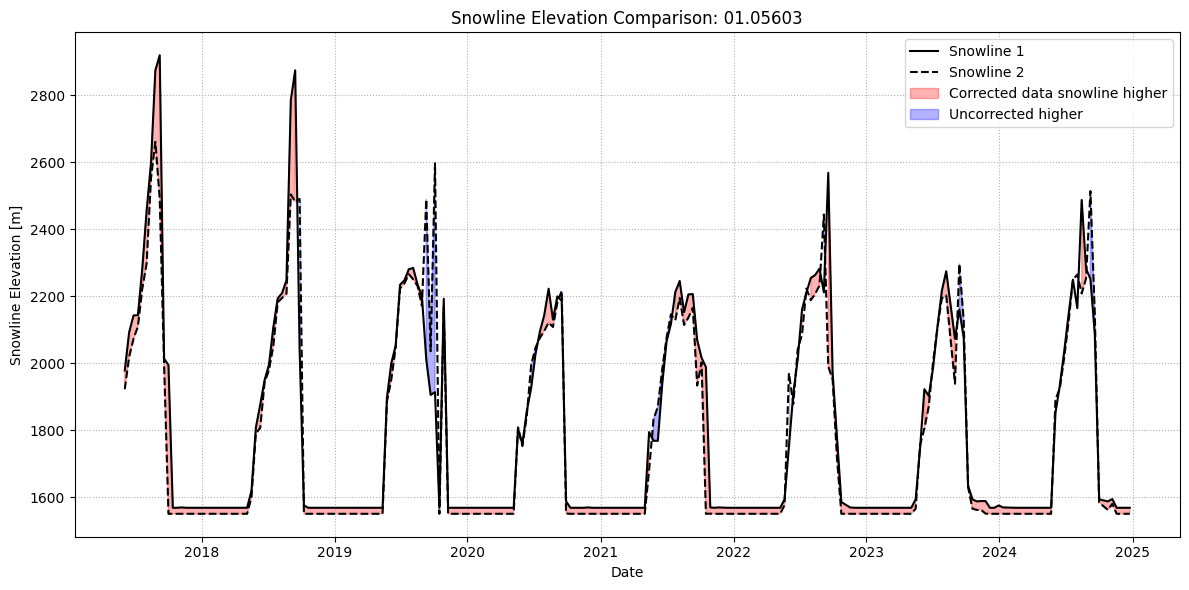

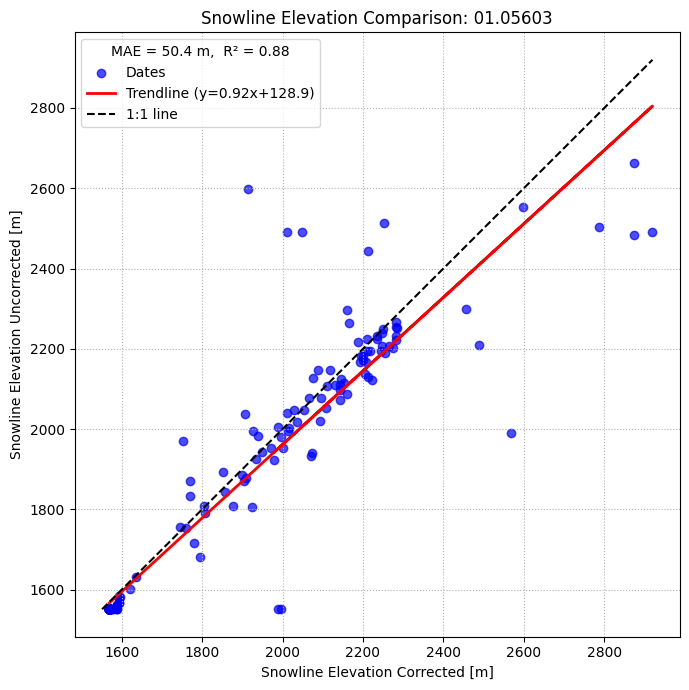

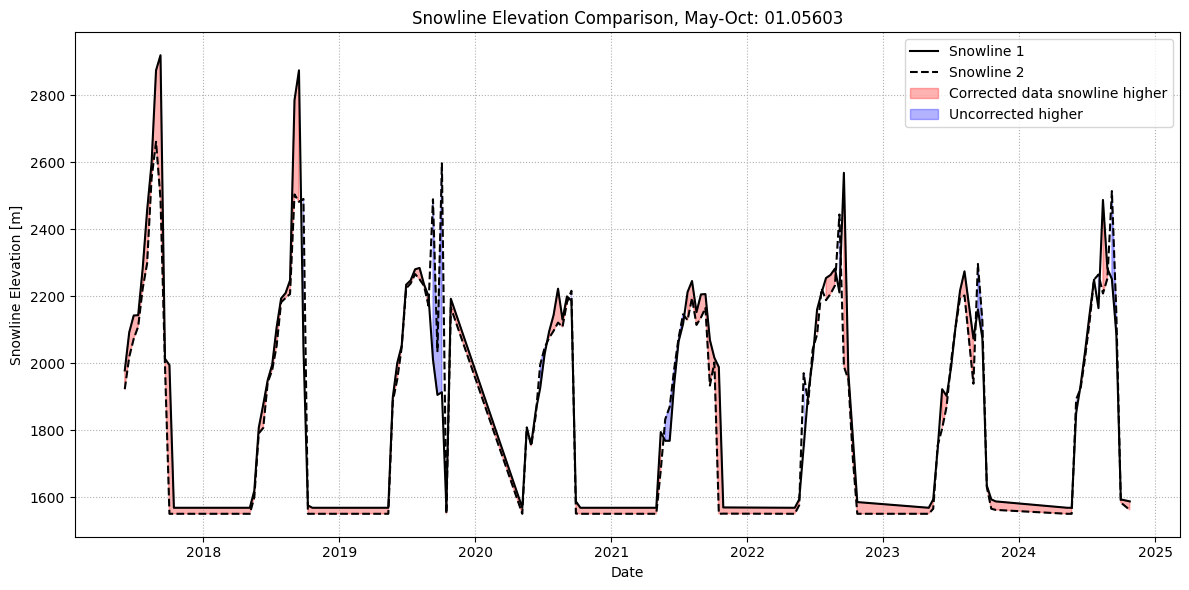

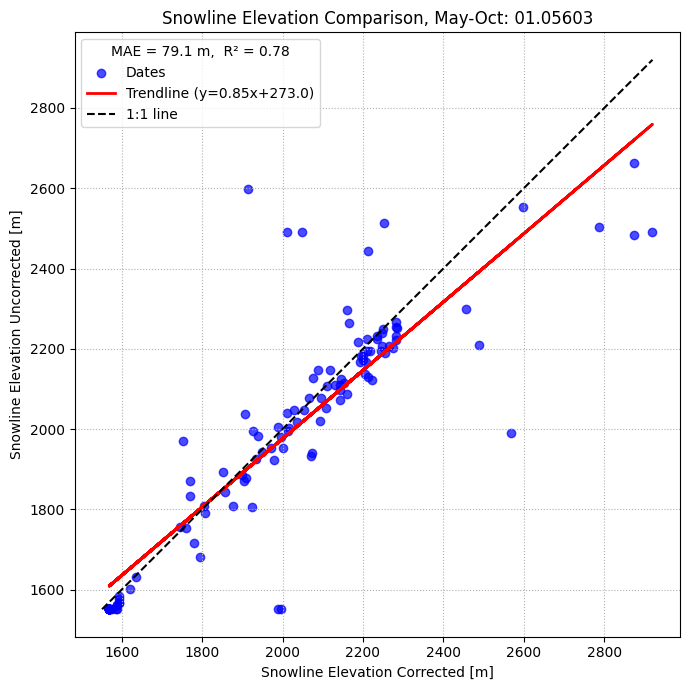

In [51]:
#for i in range(len(u_paths)):
for i in [0]:

    rgi_id_period = u_paths[i][-8:]
    rgi_fig_folder = os.path.join(fig_fp, rgi_id_period)

    if not os.path.exists(rgi_fig_folder):
        os.makedirs(rgi_fig_folder)

    csv_1 = u_glac_sl_elev_perc_z_fps_list[i][0]
    csv_2 = [x for x in corr_glac_sl_elev_perc_z_fps_list[i] if pf in x and "eos" not in x][0]

    corr_sl_df = pd.read_csv(csv_2, index_col=0, parse_dates=True)
    u_sl_df = pd.read_csv(csv_1, index_col=0, parse_dates=True)
    
    plot_sl_df(corr_sl_df, u_sl_df, rgi_fig_folder)
    ###Now, do summer:

    corr_sl_df_summer = corr_sl_df[(corr_sl_df.index.month >= 5) & (corr_sl_df.index.month <= 10)]

    u_sl_df_summer  = u_sl_df[(u_sl_df.index.month >= 5) & (u_sl_df.index.month <= 10)]

    plot_sl_df(corr_sl_df_summer, u_sl_df_summer, rgi_fig_folder, summer=True)




Melt Extent Comparison:

In [58]:
def plot_me_df(corr_me_df, u_me_df, rgi_fig_folder, summer=False):

    merged = corr_me_df[['melt_extent_elev_m']].rename(columns={'melt_extent_elev_m': 'me1'})
    merged['me2'] = u_me_df['melt_extent_elev_m']

    # Compute difference
    merged['diff'] = merged['me1'] - merged['me2']

    # Plot
    plt.figure(figsize=(12,6))

    # black straight lines (no dots)
    plt.plot(merged.index, merged['me1'], color="black", linewidth=1.5, label="Melt Extent Elevation 1")
    plt.plot(merged.index, merged['me2'], color="black", linewidth=1.5, linestyle="--", label="Melt Extent Elevation 2")

    # Highlight differences
    plt.fill_between(
        merged.index,
        merged['me1'], merged['me2'],
        where=merged['me1'] > merged['me2'],
        color='red', alpha=0.3, label="Corrected melt extent higher"
    )
    plt.fill_between(
        merged.index,
        merged['me1'], merged['me2'],
        where=merged['me1'] < merged['me2'],
        color='blue', alpha=0.3, label="Uncorrected higher"
    )

    plt.xlabel("Date")
    plt.ylabel("Melt Extent Elevation [m]")
    if summer:
        plt.title(f"Melt Extent Comparison, May-Oct: {rgi_id_period}")
    else:
        plt.title(f"Melt Extent Comparison: {rgi_id_period}")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    if summer:
        png_fp = os.path.join(rgi_fig_folder, f"me_cmp_summer_{rgi_id_period}.png")
    else:
        png_fp = os.path.join(rgi_fig_folder, f"me_cmp_{rgi_id_period}.png")
    plt.show()

    #comparison plot
    x = merged['me1'].values
    y = merged['me2'].values

    plt.figure(figsize=(7,7))
    plt.scatter(x, y, c='blue', alpha=0.7, label="Dates")

    # Add regression (trendline)
    m, b = np.polyfit(x, y, 1)   # slope, intercept
    plt.plot(x, m*x + b, color="red", linewidth=2, label=f"Trendline (y={m:.2f}x+{b:.1f})")

    # Add 1:1 line (reference line)
    lims = [
        min(min(x), min(y)),
        max(max(x), max(y))
    ]
    plt.plot(lims, lims, 'k--', linewidth=1.5, label="1:1 line")  # dashed black

    plt.xlabel("Melt Extent Elev Corrected [m]")
    plt.ylabel("Melt Extent Elev Uncorrected [m]")
    if summer:
        plt.title(f"Melt Extent Elevation Comparison, May-Oct: {rgi_id_period}")
    else:
        plt.title(f"Melt Extent Elevation Comparison: {rgi_id_period}")
    #compute MAE, R^2
    mae = np.mean(np.abs(y - x))
    r2 = np.corrcoef(x, y)[0, 1] ** 2
    plt.legend(title=f"MAE = {mae:.1f} m,  R² = {r2:.2f}")
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    if summer:
        png_fp = os.path.join(rgi_fig_folder, f"me_dot_cmp_summer_{rgi_id_period}.png")
    else:
        png_fp = os.path.join(rgi_fig_folder, f"me_dot_cmp_{rgi_id_period}.png")
    plt.savefig(png_fp, dpi=300, bbox_inches='tight')  # high-quality PNG

    plt.show()

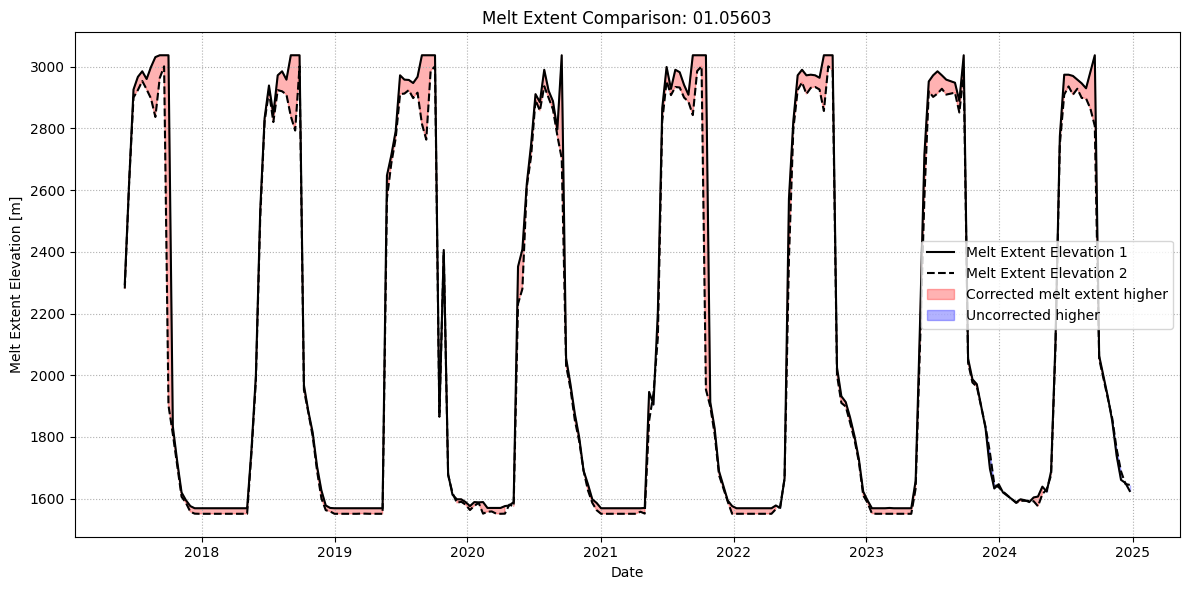

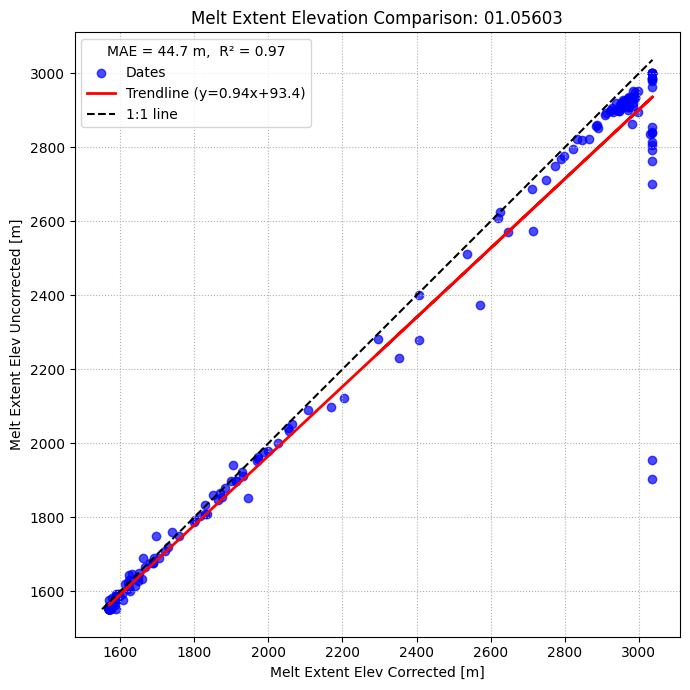

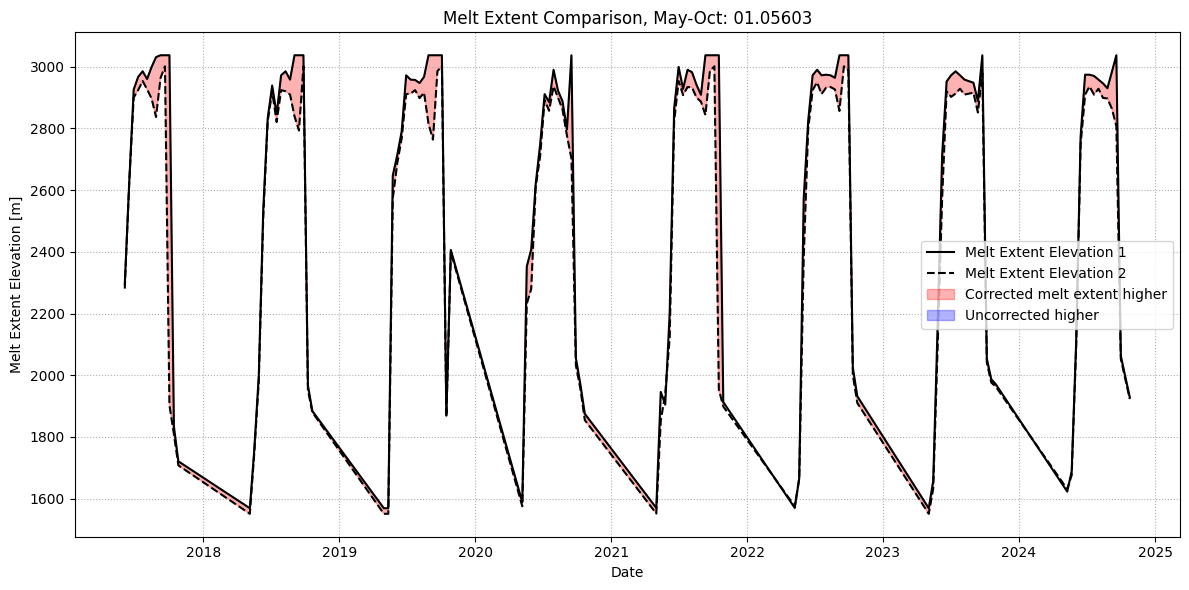

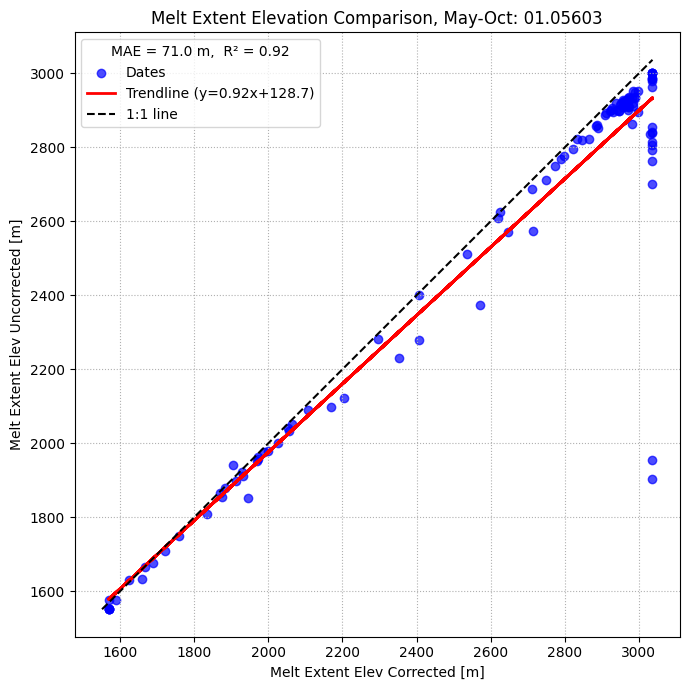

In [60]:
for i in [0]:

    rgi_id_period = u_paths[i][-8:]
    rgi_fig_folder = os.path.join(fig_fp, rgi_id_period)

    if not os.path.exists(rgi_fig_folder):
        os.makedirs(rgi_fig_folder)

    csv_1 = u_glac_me_elev_perc_z_fps_list[i][0]
    csv_2 = [x for x in corr_glac_me_elev_perc_z_fps_list[i] if pf in x and "eos" not in x][0]

    corr_me_df = pd.read_csv(csv_2, index_col=0, parse_dates=True)
    u_me_df = pd.read_csv(csv_1, index_col=0, parse_dates=True)
    
    plot_me_df(corr_me_df, u_me_df, rgi_fig_folder)
    ###Now, do summer:

    corr_me_df_summer = corr_me_df[(corr_me_df.index.month >= 5) & (corr_me_df.index.month <= 10)]

    u_me_df_summer  = u_me_df[(u_me_df.index.month >= 5) & (u_me_df.index.month <= 10)]

    plot_me_df(corr_me_df_summer, u_me_df_summer, rgi_fig_folder, summer=True)



Heatmaps:

In [65]:
RGI_shapefile_path = "C:/Users/jaden/Downloads/Research/Glaciers/RGI2000-v7.0-G-01_alaska/RGI2000-v7.0-G-01_alaska.shp"

# extract and clean the data, excluding null glac_name values
rgi_gdf = gpd.read_file(RGI_shapefile_path)
glac_name_dict = {
    int(row['rgi_id'][-5:]): row['glac_name'].replace(" Glacier", "").replace("_abl", "").strip()
    for _, row in rgi_gdf.iterrows()
    if pd.notnull(row['glac_name']) and row['area_km2'] >= 1 
}
glac_name_dict


{75: 'West Alapah',
 77: 'East Alapah',
 170: 'Windy',
 228: 'Pangnik',
 253: 'Chamberlin',
 329: 'Split',
 368: 'Leffingwell',
 378: 'Esetuk',
 390: 'Bravo',
 399: 'Arey',
 573: 'Okpilak',
 581: 'Schwanda',
 582: 'Hubley',
 587: 'Gooseneck',
 592: 'McCall',
 594: 'Contact',
 724: 'Chikuminuk',
 1037: 'Chigmit North',
 1298: 'Aho',
 1334: 'Double',
 1335: 'Double',
 1495: 'Neacola',
 1595: 'Blockade',
 1696: 'McArthur',
 1808: 'Tanaina',
 1862: 'TlikakilaGlacierFork',
 2238: 'North Twin',
 2246: 'South Twin',
 2253: 'Harpoon',
 2411: 'Hayes',
 2458: 'Black and Tan',
 2509: 'Trimble',
 2580: 'Triumvirate',
 2593: 'Capps',
 2595: 'Dogshead',
 2602: 'Pothole',
 2603: 'Barrier',
 2605: 'Crater',
 2613: "Ch'atanalch'elt Li'a",
 2739: 'Stony',
 2760: 'Tired Pup',
 3065: 'Revelation',
 3166: 'Tourquise',
 3377: 'Chigmuit South',
 3393: 'Tongue',
 3447: 'Double',
 3451: 'Johnson',
 3504: 'Tuxedni',
 3581: 'Lateral',
 3582: 'Red',
 3588: 'Umbrella',
 3611: 'TlikakilaNorthFork',
 3727: 'Tatina',

In [120]:
def plot_db_heatmap_diff(csv_fn1, csv_fn2, glacno, glac_name_dict={}, 
                         cmap='RdBu_r', cbar_label='Change dB (Corr - Uncorr)', 
                         ylabel='Elevation [m a.s.l.]', fig_fn=None, figsize=(9,6),
                         bins2plot_lowerquantile=2, bins2plot_upperquantile=98,
                         frame_cut=0, title_info='', **kwargs):
    """
    Plot difference heatmap between two db_bin CSVs (e.g., corrected - uncorrected).

    Parameters
    ----------
    csv_fn1, csv_fn2 : str
        Paths to db_bin CSVs (must share same bin structure and date index)
    glacno : int
        Glacier number
    glac_name_dict : dict
        Optional {glacno: name} mapping for title
    """
    # === Load both CSVs ===
    db_bin_1 = pd.read_csv(csv_fn1, index_col=0)
    db_bin_2 = pd.read_csv(csv_fn2, index_col=0)


    # Interpolate corrected onto uncorrected's grid
    

   
    # Ensure both DataFrames are sorted by elevation
    db_bin_1 = db_bin_1.sort_index()
    db_bin_2 = db_bin_2.sort_index()

    # Interpolate corrected data to uncorrected elevation bins (rows)
    db_bin_1_interp = pd.DataFrame(
        index=db_bin_2.index,  # target elevations
        columns=db_bin_2.columns,  # same dates
        data=np.empty((len(db_bin_2.index), len(db_bin_2.columns))) * np.nan
    )

    # Interpolate column-by-column along elevation (axis=0)
    for c in db_bin_2.columns:
        valid = db_bin_1[c].dropna()
        if len(valid) > 1:
            db_bin_1_interp.loc[:, c] = np.interp(
                db_bin_2.index, valid.index, valid.values, left=np.nan, right=np.nan
            )

    
    db_bin_1 = db_bin_1_interp
    
    

    
    # Ensure same shapes/dates
    assert np.allclose(db_bin_1.index.values, db_bin_2.index.values), "Elevation bins differ!"
    common_dates = db_bin_1.columns.intersection(db_bin_2.columns)
    db_bin_1 = db_bin_1[common_dates]
    db_bin_2 = db_bin_2[common_dates]
    corr = db_bin_1
    uncorr = db_bin_2



    # === Compute difference ===
    db_bin_diff = corr - uncorr
    
    bins_center = db_bin_diff.index.values.astype(float)
    dates = pd.to_datetime(common_dates)

    # Optional subsetting by frame_cut
    if frame_cut > 0:
        db_bin_diff = db_bin_diff.iloc[:, frame_cut:]
        dates = dates[frame_cut:]
    
    # === Downsample to 12-day intervals for readability ===
    dates_12d = pd.date_range(dates[0], dates[-1], freq='12D')
    db_bin_12d = np.full((len(bins_center), len(dates_12d)), np.nan)
    for ndate, date in enumerate(dates_12d):
        if date in dates.values:
            idx = np.where(dates == date)[0][0]
            db_bin_12d[:, ndate] = db_bin_diff.iloc[:, idx]

    # === Plot ===
    fig, ax = plt.subplots(figsize=figsize)

    vmin = np.nanpercentile(db_bin_diff.values, bins2plot_lowerquantile)
    vmax = np.nanpercentile(db_bin_diff.values, bins2plot_upperquantile)

    cax = ax.imshow(db_bin_12d, cmap=cmap, vmin=vmin, vmax=vmax,
                    interpolation='nearest', aspect='auto',
                    origin='lower', extent=[dates_12d[0], dates_12d[-1], bins_center[0], bins_center[-1]])

    # Add optional line overlays
    line_plot = kwargs.get('line_plot', [])
    if line_plot:
        for data in line_plot:
            x, y, c, ls, lw, label = data
            ax.plot(x, y, c=c, ls=ls, lw=lw, label=label)
        ax.legend(loc='lower right')

    # Titles and labels
    glac_name = glac_name_dict.get(glacno, str(glacno))
    ax.set_title(f"{glac_name} — Difference Heatmap (Corr − Uncorr){title_info}")
    ax.set_ylabel(ylabel)
    ax.set_xlim([dates_12d[0], dates_12d[-1]])
    ax.set_ylim([bins_center[0], bins_center[-1]])

    # Colorbar
    cbar = fig.colorbar(cax, orientation='vertical', label=cbar_label)

    # Save or show
    if fig_fn:
        plt.savefig(fig_fn, dpi=300, transparent=True, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


In [62]:
def plot_db_heatmap(db_bin, dates, bins_center, binned_area, set_ymin, set_ymax, glacno, cmap='RdYlBu', cbar_label='db', 
                    ylabel='Elevation [m a.s.l.]', glac_name_dict={}, fig_fn=None, figsize=(9,6), bins2plot_lowerquantile=2, 
                    bins2plot_upperquantile=98, frame_cut=0, title_info='', **kwargs):
    """" Heatmap plotting function """
    fig, ax = plt.subplots(figsize=figsize)
    
    dates_12d = pd.date_range(dates[frame_cut], dates[-1], freq='12D')
    dates_12d_str = [x.strftime('%Y%m%d') for x in dates_12d]
    db_bin_12d = np.zeros((db_bin.shape[0], len(dates_12d)))
    db_bin_12d[:] = np.nan
    dates_str = []
    for ndate, date in enumerate(dates_12d_str):
        date_np = np.datetime64(f'{date[:4]}-{date[4:6]}-{date[6:]}').astype('datetime64[ns]')
        if date_np in dates:
            date_idx = np.where(dates == date_np)[0][0]
            db_bin_12d[:,ndate] = db_bin[:,date_idx]
            dates_str.append(date)

    dbmin = np.nanpercentile(db_bin, 2)
    dbmax = np.nanpercentile(db_bin, 98)

    bin_sizes = np.diff(bins_center)
    bin_halfsize = bin_sizes[0]/2
    if ylabel == 'Elevation [m a.s.l.]':
        assert np.all(bin_sizes == bin_sizes[0]) == True, 'Elevation bins are not regularly spaced.'

    cax = ax.imshow(db_bin_12d, cmap=cmap, vmin=dbmin, vmax=dbmax, interpolation='nearest', aspect='auto', 
                    origin='lower', extent=[dates_12d[0], dates_12d[-1], set_ymin, set_ymax])

    # plot additional data from **kwargs
    line_plot = kwargs.get('line_plot', [])
    if line_plot:
        for data in line_plot:
            x, y, c, ls, lw, label = data
            ax.plot(x, y, c=c, ls=ls, lw=lw, label=label)
        ax.legend(loc='lower right')

    # label by glacier number or name, if available
    if glacno in glac_name_dict.keys():
        glac_name = glac_name_dict[glacno]
    else:
        glac_name = str(glacno)
    ax.set_title(glac_name+title_info)
    ax.set_ylabel(ylabel)
    ax.set_xlim([dates_12d[0], dates_12d[-1]])
    ax.set_ylim([set_ymin, set_ymax])
    cbar = fig.colorbar(cax, orientation='vertical', label=cbar_label)

    if fig_fn is not None:
        plt.savefig(fig_fn, dpi=300, transparent='true', bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        

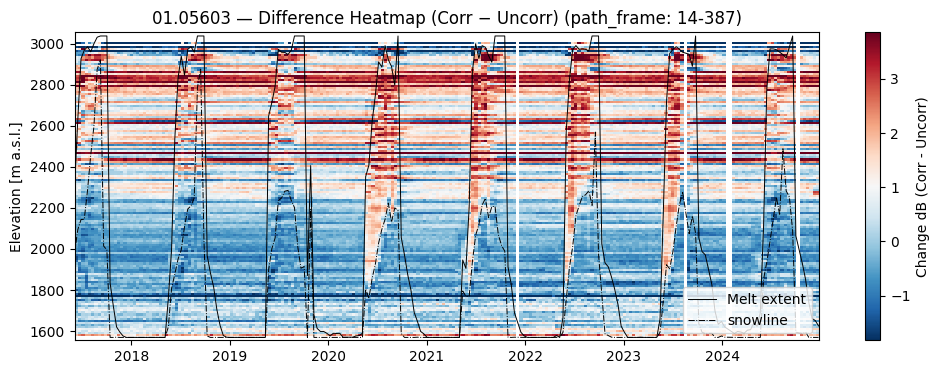

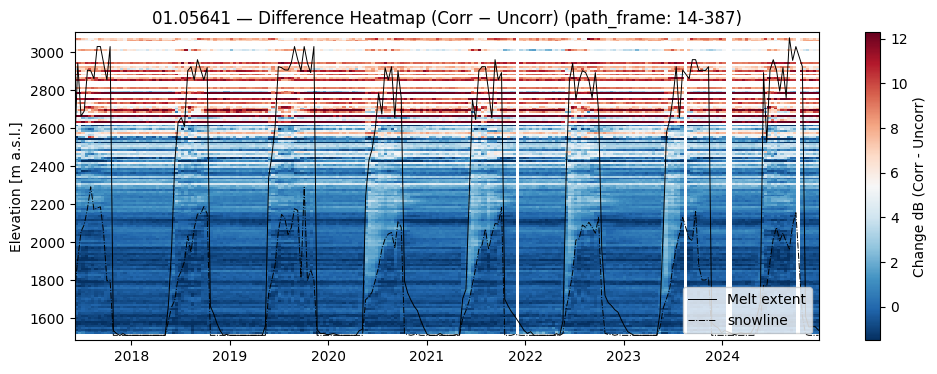

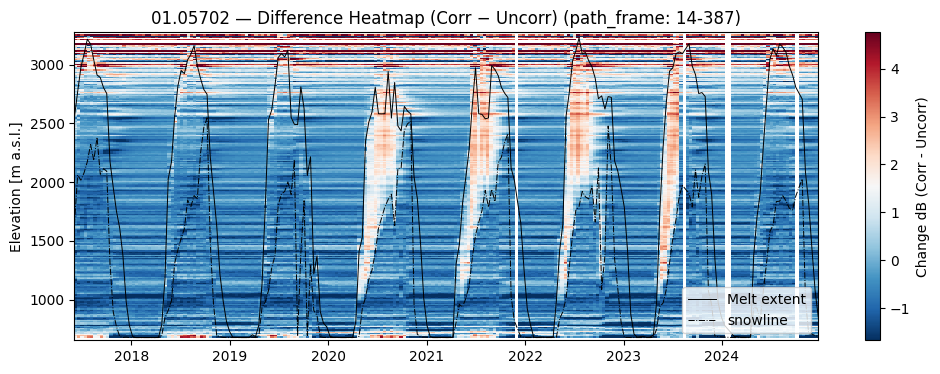

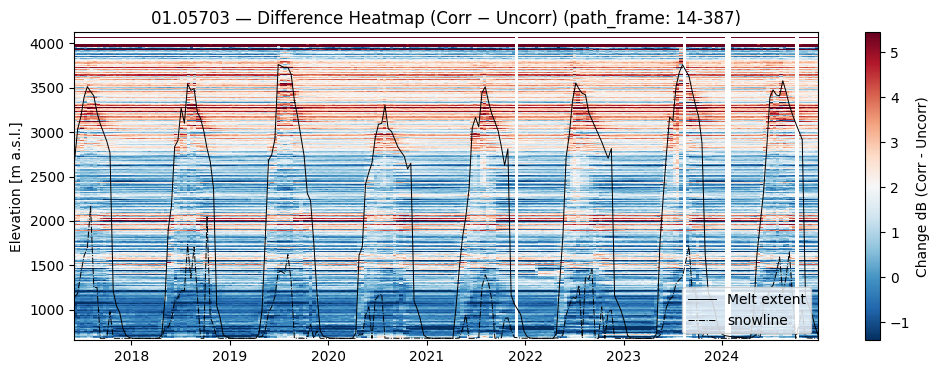

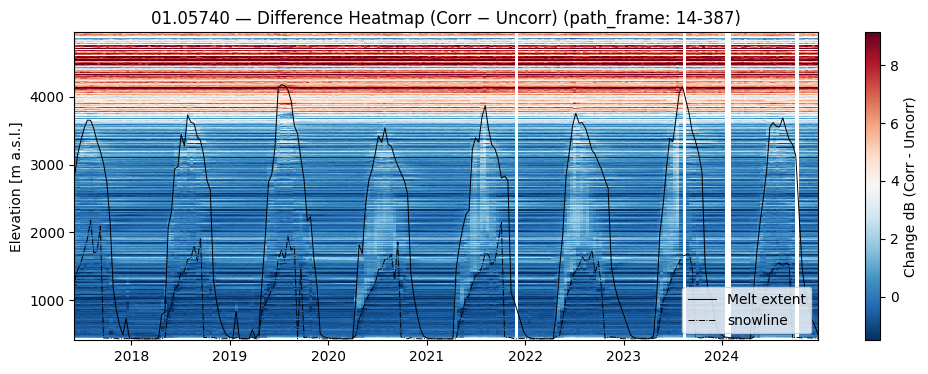

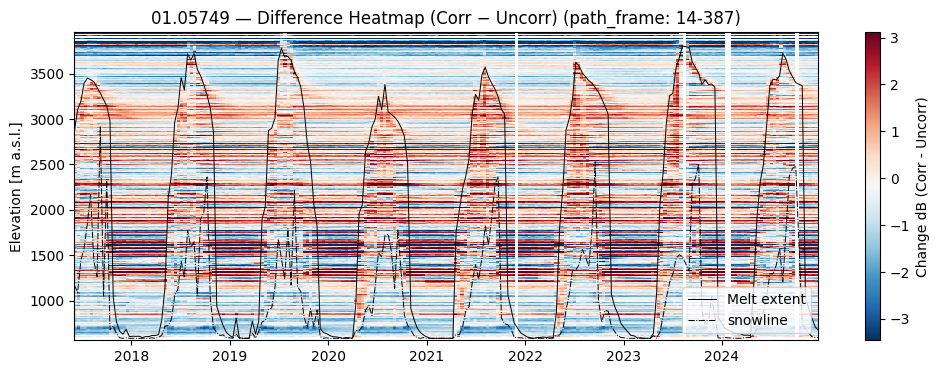

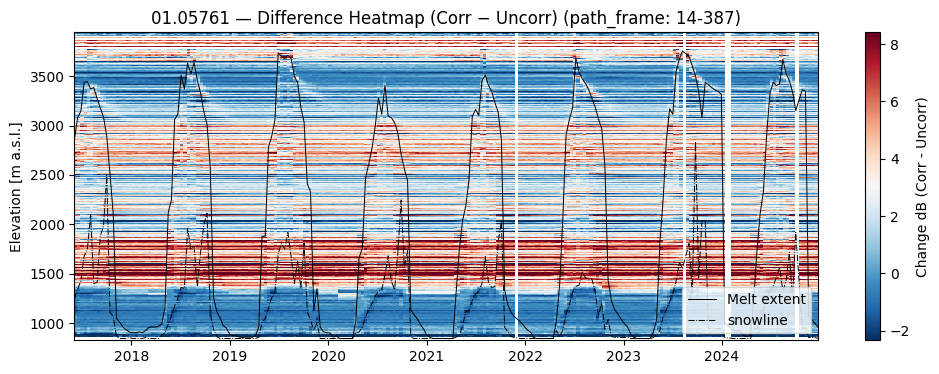

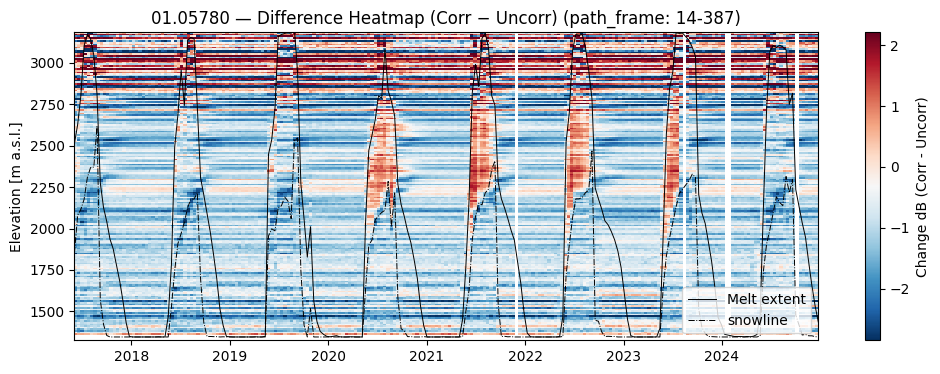

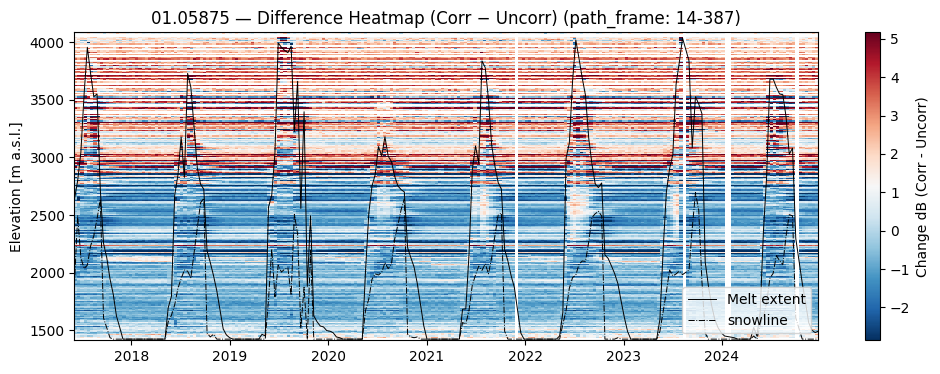

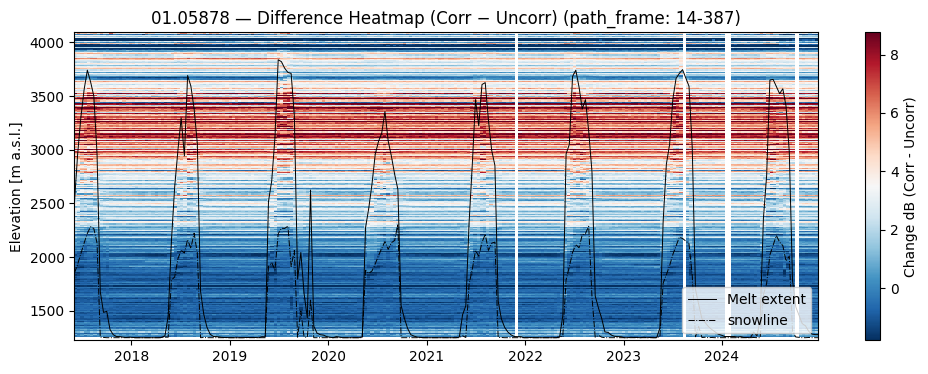

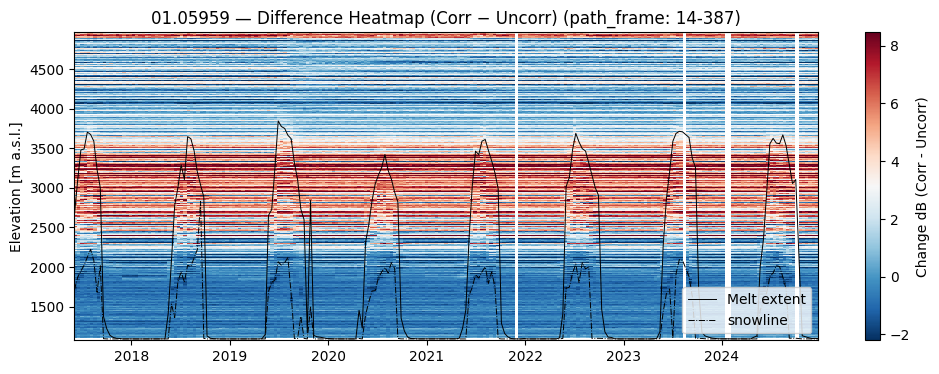

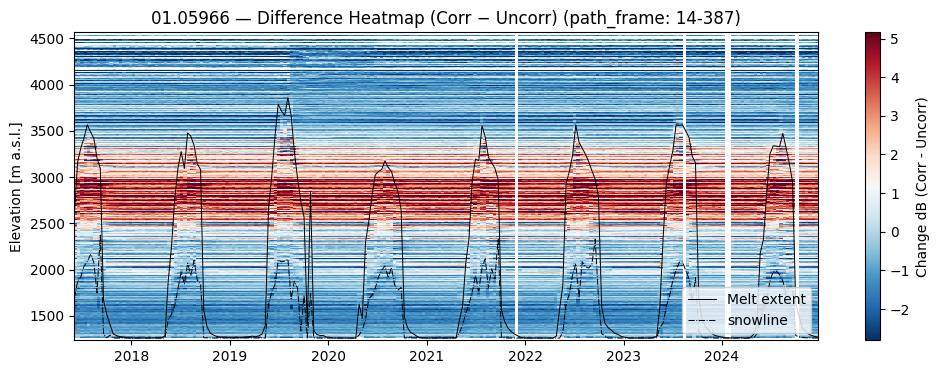

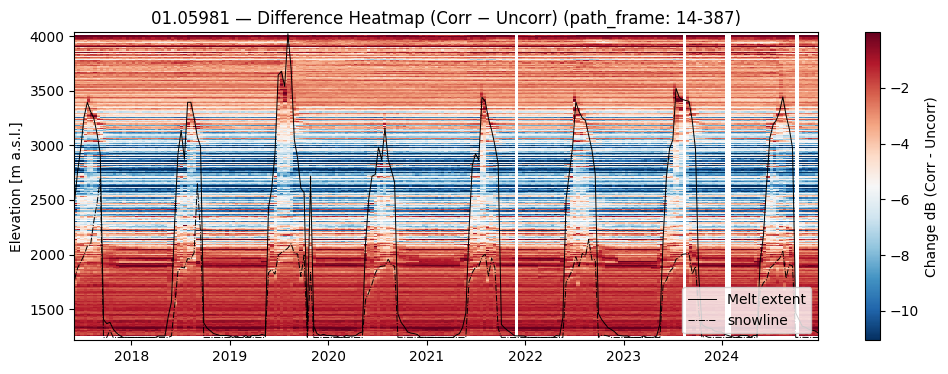

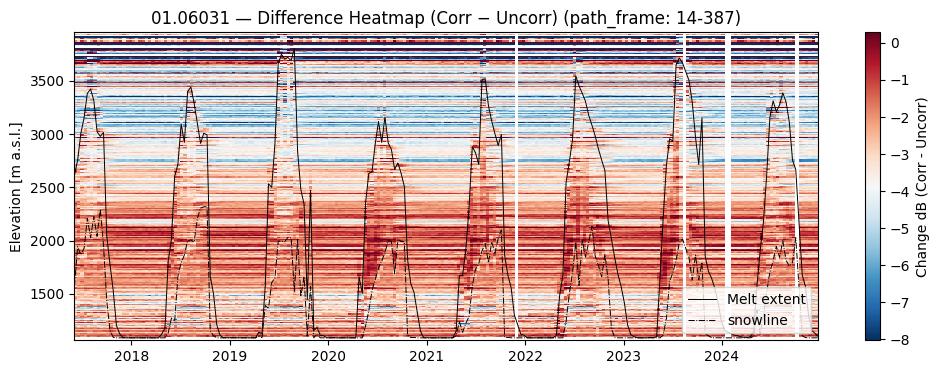

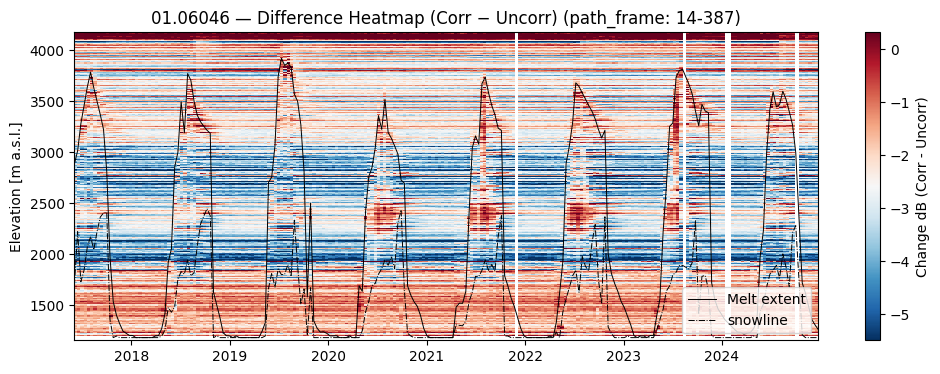

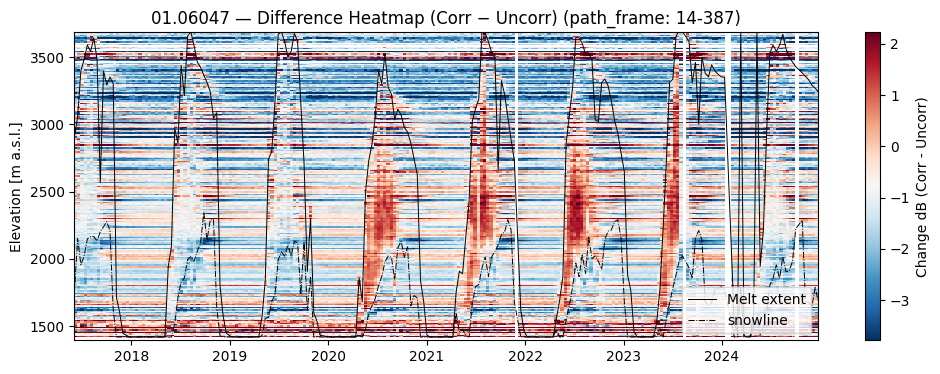

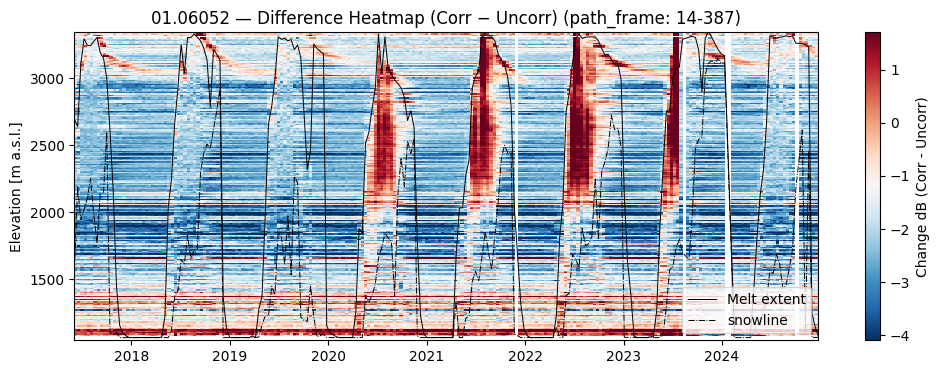

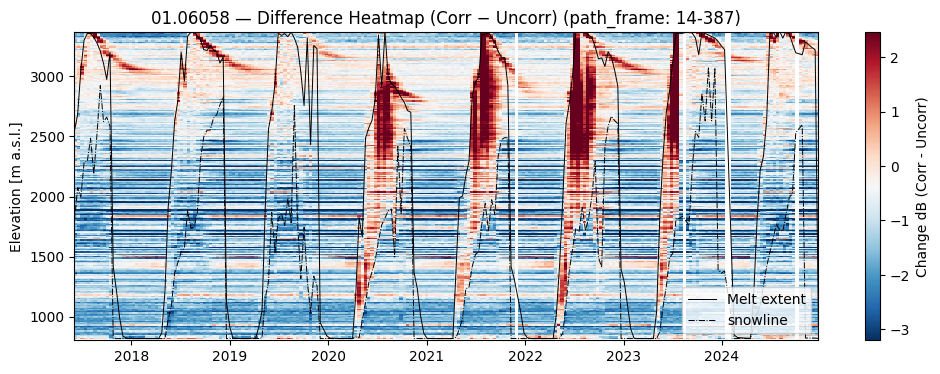

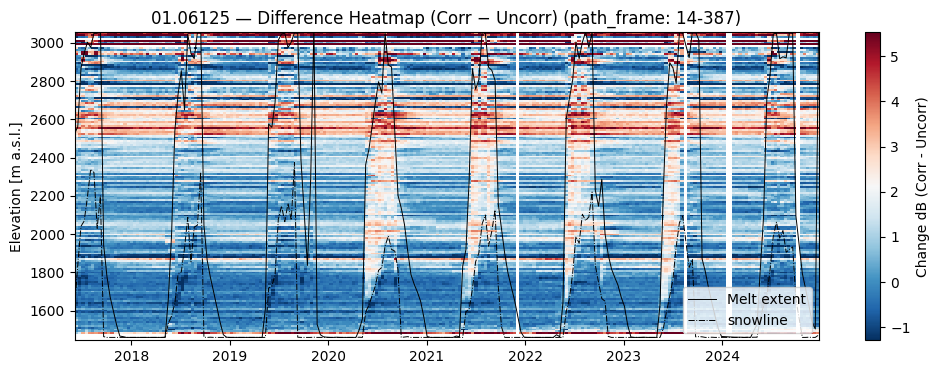

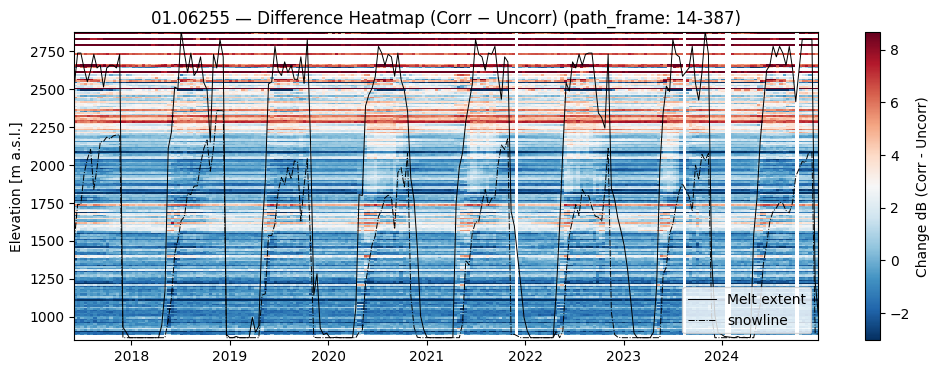

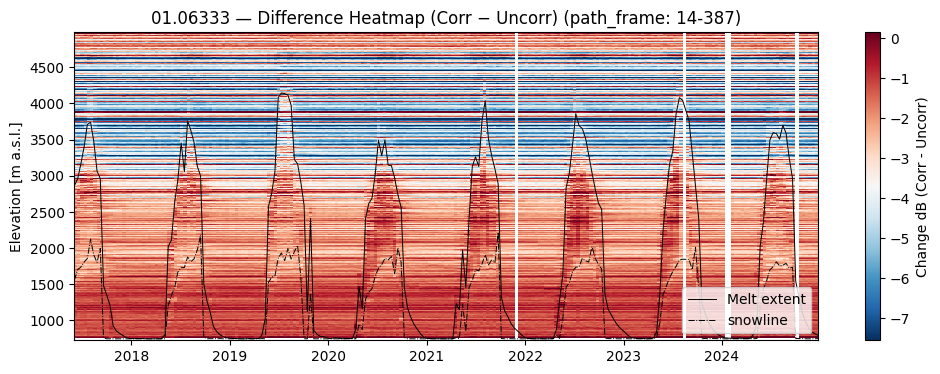

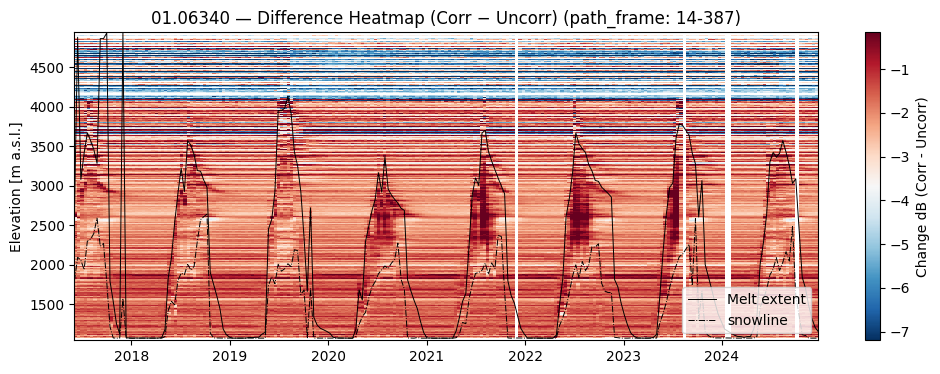

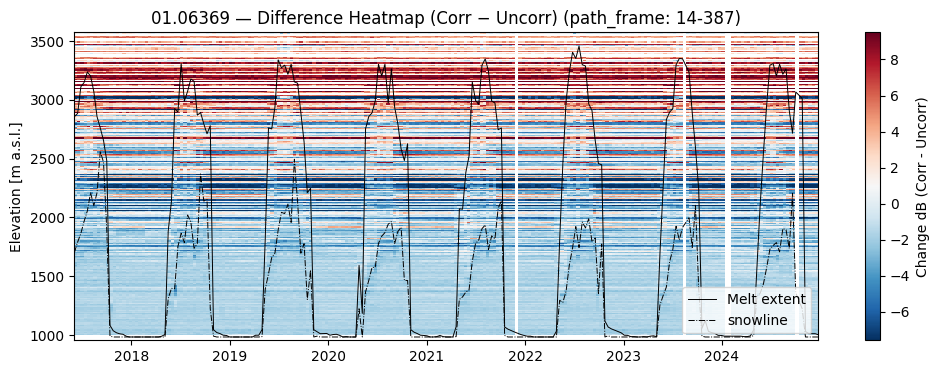

In [119]:
# load necessary files
for i in range(len(u_paths)):


    rgi_id_period = u_paths[i][-8:]
    rgi_fig_folder = os.path.join(fig_fp, rgi_id_period)
    if not os.path.exists(rgi_fig_folder):
        os.makedirs(rgi_fig_folder)


    for (u_glac_db_mean_fp, u_glac_me_elev_perc_fp, u_glac_sl_elev_perc_fp, u_glac_hyps_fp,
         corr_glac_db_mean_fp, corr_glac_me_elev_perc_fp, corr_glac_sl_elev_perc_fp, corr_glac_hyps_fp) in zip(u_glac_db_mean_z_fps_list[i], u_glac_me_elev_perc_z_fps_list[i],
                                                                                        u_glac_sl_elev_perc_z_fps_list[i], u_glac_hyps_z_fps_list[i],
                                                                                        corr_glac_db_mean_z_fps_list[i], corr_glac_me_elev_perc_z_fps_list[i],
                                                                                        corr_glac_sl_elev_perc_z_fps_list[i], corr_glac_hyps_z_fps_list[i]): 
        
        db_bin_mean_df = pd.read_csv(u_glac_db_mean_fp, index_col=0) # load the db_bin_mean file
        # db_bin_mean_df = dates_filter_for_plotting(db_bin_mean_df, date_start='2017-01-01', date_end='2022-12-01') # filter by dates

        #Use corrected data for snowlines, extents, hypsometry
        glac_me_elev_perc_df = pd.read_csv(corr_glac_me_elev_perc_fp, index_col=0)
        glac_sl_elev_perc_df = pd.read_csv(corr_glac_sl_elev_perc_fp, index_col=0)
        hypsometry_df = pd.read_csv(corr_glac_hyps_fp, index_col=0) # load the hypsometry file (one per glacier)
        glac_zbins_center = np.array(hypsometry_df.index.tolist())
        glac_bin_sizes = np.diff(glac_zbins_center)
        glac_bin_halfsize = glac_bin_sizes[0]/2
        binned_area = np.array(hypsometry_df.iloc[:, 0].tolist())
        
        # extract data
        dates = np.array(db_bin_mean_df.columns.tolist()).astype('datetime64[ns]')
        glac_binned_data = np.array(db_bin_mean_df.to_numpy())

        dates_per = np.array(glac_me_elev_perc_df.index.tolist()).astype('datetime64[ns]')
        me_elev_per = np.array(glac_me_elev_perc_df.iloc[:, 0].tolist())
        dates_sl_per = np.array(glac_sl_elev_perc_df.index.tolist()).astype('datetime64[ns]')
        sl_elev_per = np.array(glac_sl_elev_perc_df.iloc[:, 0].tolist())

        fig_fn_w_me_elev = os.path.join(rgi_fig_folder, f"db_heatmap_{rgi_id_period}.png")
        title_info = ' (path_frame: ' + u_glac_db_mean_fp.split('_db_bin_mean_')[1].split('.csv')[0] + ')'
        set_ymin, set_ymax = glac_zbins_center[0]-glac_bin_halfsize, glac_zbins_center[-1]+glac_bin_halfsize
        
        # plot and save each data
        # plot_db_heatmap(glac_binned_data, dates, glac_zbins_center, binned_area, set_ymin, set_ymax, rgi_id_period, fig_fn=fig_fn_w_me_elev, 
        #                 glac_name_dict=glac_name_dict, figsize=(12,4), title_info=title_info,
        #                 line_plot=[(dates_per, me_elev_per, 'k', '-', 0.7, 'Melt extent'),
        #                         (dates_sl_per, sl_elev_per, 'k', '-.', 0.7, 'Snowline')])
        # plot_db_heatmap(glac_binned_data, dates, glac_zbins_center, binned_area, set_ymin, set_ymax, rgi_id_period, fig_fn=None, 
        #                 glac_name_dict=glac_name_dict, figsize=(12,4), title_info=title_info,
        #                 line_plot=[(dates_per, me_elev_per, 'k', '-', 0.7, 'Melt extent'),
        #                         (dates_sl_per, sl_elev_per, 'k', '-.', 0.7, 'snowline')])

        #Difference them:

        plot_db_heatmap_diff(corr_glac_db_mean_fp, u_glac_db_mean_fp, rgi_id_period, glac_name_dict=glac_name_dict, fig_fn=None, 
                        figsize=(12,4), title_info=title_info,
                        line_plot=[(dates_per, me_elev_per, 'k', '-', 0.7, 'Melt extent'),
                                (dates_sl_per, sl_elev_per, 'k', '-.', 0.7, 'snowline')])
        
        # plot_db_heatmap_diff(corr_glac_db_mean_fp, u_glac_db_mean_fp, rgi_id_period, glac_name_dict=glac_name_dict, fig_fn=fig_fn_w_me_elev, 
        #                 figsize=(12,4), title_info=title_info,
        #                 line_plot=[(dates_per, me_elev_per, 'k', '-', 0.7, 'Melt extent'),
        #                         (dates_sl_per, sl_elev_per, 'k', '-.', 0.7, 'snowline')])

